In [1]:
%%capture
%pylab inline --no-import-all
import math
import numpy
#import utils
import matplotlib.pyplot as plt

from QuantLib import *

In [2]:
today = Date(11, December, 2012)
Settings.instance().evaluationDate = today


# OIS curve

In [4]:
eonia = Eonia()
helpers = [ DepositRateHelper(QuoteHandle(SimpleQuote(rate/100)), 
                              Period(1,Days), 
                              fixingDays, 
                              TARGET(), 
                              Following, 
                              False, 
                              Actual360()) 
           for rate, fixingDays in [(0.04, 0), (0.04, 1), (0.04, 2)] ]

helpers += [ OISRateHelper(2, Period(*tenor), QuoteHandle(SimpleQuote(rate/100)), eonia)
            for rate, tenor in [(0.070, (1,Weeks)), 
                                (0.069, (2,Weeks)), 
                                (0.078, (3,Weeks)), 
                                (0.074, (1,Months))]]
helpers += [ DatedOISRateHelper(start_date, end_date, QuoteHandle(SimpleQuote(rate/100)), eonia) 
            for rate, start_date, end_date in [(0.046, Date(16,January,2013), Date(13,February,2013)),
                                               (0.016, Date(13,February,2013), Date(13,March,2013)),
                                               (-0.007, Date(13,March,2013), Date(10,April,2013)),
                                               (-0.013, Date(10,April,2013), Date(8,May,2013)),
                                               (-0.014, Date(8,May,2013), Date(12,June,2013))]]
helpers += [ OISRateHelper(2, Period(*tenor), QuoteHandle(SimpleQuote(rate/100)), eonia)
            for rate, tenor in [(0.002, (15,Months)), (0.008, (18,Months)),
                                (0.021, (21,Months)), (0.036, (2,Years)),
                                (0.127, (3,Years)), (0.274, (4,Years)),
                                (0.456, (5,Years)), (0.647, (6,Years)),
                                (0.827, (7,Years)), (0.996, (8,Years)),
                                (1.147, (9,Years)), (1.280, (10,Years)),
                                (1.404, (11,Years)), (1.516, (12,Years)),
                                (1.764, (15,Years)), (1.939, (20,Years)),
                                (2.003, (25,Years)), (2.038, (30,Years))] ]
jumps = [QuoteHandle(SimpleQuote(math.exp(-J*2.0/360))) for J in [0.00102, 0.00086]]
jump_dates = [Date(31,December,2012), Date(31,December,2013)]

#eonia_curve_c = PiecewiseLogCubicDiscount(0, TARGET(), helpers, Actual365Fixed())
eonia_curve = PiecewiseLogCubicDiscount(2, TARGET(), helpers, Actual365Fixed(), jumps, jump_dates)
eonia_curve.enableExtrapolation()


# Euribor 6m

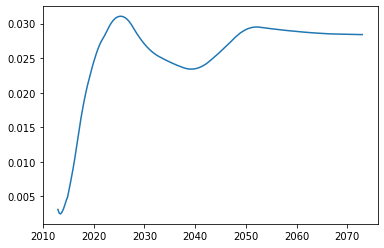

In [5]:
helpers = [ DepositRateHelper(QuoteHandle(SimpleQuote(0.312/100)), 
                              Period(6,Months), 
                              3, 
                              TARGET(), 
                              Following, 
                              False, 
                              Actual360()) ]
euribor6m = Euribor6M()
helpers += [ FraRateHelper(QuoteHandle(SimpleQuote(rate/100)), start, euribor6m) 
            for rate, start in [(0.293, 1), (0.272, 2), (0.260, 3),
                                (0.256, 4), (0.252, 5), (0.248, 6),
                                (0.254, 7), (0.261, 8), (0.267, 9),
                                (0.279, 10), (0.291, 11), (0.303, 12),
                                (0.318, 13), (0.335, 14), (0.352, 15),
                                (0.371, 16), (0.389, 17), (0.409, 18)] ]
discount_curve = RelinkableYieldTermStructureHandle()
discount_curve.linkTo(eonia_curve)

helpers += [ SwapRateHelper(QuoteHandle(SimpleQuote(rate/100)), 
                            Period(tenor, Years), 
                            TARGET(),
                            Annual, 
                            Unadjusted,
                            Thirty360(Thirty360.BondBasis),
                            euribor6m, 
                            QuoteHandle(), 
                            Period(0, Days),
                            discount_curve) 
            for rate, tenor in [(0.424, 3), (0.576, 4), (0.762, 5),
                                (0.954, 6), (1.135, 7), (1.303, 8),
                                (1.452, 9), (1.584, 10), (1.809, 12),
                                (2.037, 15), (2.187, 20), (2.234, 25),
                                (2.256, 30), (2.295, 35), (2.348, 40),
                                (2.421, 50), (2.463, 60)] ]

euribor6m_curve = PiecewiseLogCubicDiscount(2, TARGET(), helpers, Actual365Fixed())
euribor6m_curve.enableExtrapolation()

spot = euribor6m_curve.referenceDate()
dates = [ spot+Period(i,Months) for i in range(0, 60*12+1) ]
rates = [ euribor6m_curve.forwardRate(d, 
                                      euribor6m.maturityDate(d), 
                                      Actual360(), 
                                      Simple).rate() for d in dates ]

plt.plot([d.to_date() for d in dates], rates)

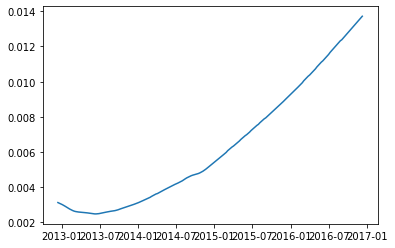

In [7]:
dates = [ spot+Period(i,Weeks) for i in range(0, 52*4+1) ]
rates = [ euribor6m_curve.forwardRate(d, 
                                      euribor6m.maturityDate(d), 
                                      Actual360(), 
                                      Simple).rate() for d in dates ]
plt.plot([d.to_date() for d in dates], rates)

In [9]:
euribor6m_curve_0 = euribor6m_curve
d = TARGET().advance(spot, 1, Days)
F_x = euribor6m_curve_0.forwardRate(d, 
                                    TARGET().advance(d, 6, Months), 
                                    Actual360(), 
                                    Simple).rate()
F_on = eonia_curve.forwardRate(d, TARGET().advance(d, 6, Months), Actual360(), Simple).rate()
day_counter = euribor6m.dayCounter()
T_x = day_counter.yearFraction(d, TARGET().advance(d, 6, Months))
alpha = (F_x - F_on)
print(alpha)

0.002949286970370156


In [11]:
synth_helpers = []
for n, units in [(1,Days), (1,Weeks), (2,Weeks), (3,Weeks), 
                 (1, Months), (2, Months), (3, Months),(4, Months), (5, Months)]:
    t = day_counter.yearFraction(spot, TARGET().advance(spot, n, units))
    F_on = eonia_curve.forwardRate(spot, 
                                   TARGET().advance(spot, n, units), 
                                   Actual360(), 
                                   Simple).rate()
    F = F_on + alpha
    print(Period(n,units), F)
    synth_helpers.append(DepositRateHelper(QuoteHandle(SimpleQuote(F)), 
                                           Period(n, units), 
                                           2, 
                                           TARGET(), 
                                           Following, 
                                           False, 
                                           Actual360()))

1D 0.0033492869703727764
1W 0.003649286970837229
2W 0.0036392869702953114
3W 0.0037292869703078914
1M 0.003689286970252102
2M 0.0035588675064121356
3M 0.003419003234764449
4M 0.00327201553910815
5M 0.0031877048704152017


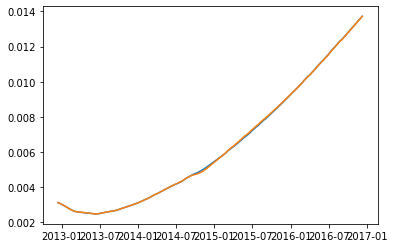

In [12]:
euribor6m_curve = PiecewiseLogCubicDiscount(2, 
                                            TARGET(), 
                                            helpers+synth_helpers, 
                                            Actual365Fixed())
euribor6m_curve.enableExtrapolation()

dates = [ spot+Period(i,Weeks) for i in range(0, 52*4+1) ]
rates_0 = [ euribor6m_curve_0.forwardRate(d, 
                                          euribor6m.maturityDate(d), 
                                          Actual360(), 
                                          Simple).rate() for d in dates ]
rates = [ euribor6m_curve.forwardRate(d, 
                                      euribor6m.maturityDate(d), 
                                      Actual360(), 
                                      Simple).rate() for d in dates ]


plt.plot([d.to_date() for d in dates], rates)
plt.plot([d.to_date() for d in dates], rates_0)

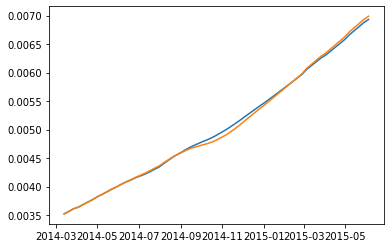

In [13]:
dates = [ spot+Period(i,Weeks) for i in range(65, 130) ]
rates_0 = [ euribor6m_curve_0.forwardRate(d, 
                                          euribor6m.maturityDate(d), 
                                          Actual360(), 
                                          Simple).rate() for d in dates ]
rates = [ euribor6m_curve.forwardRate(d, 
                                      euribor6m.maturityDate(d),
                                      Actual360(), 
                                      Simple).rate() for d in dates ]

plt.plot([d.to_date() for d in dates], rates)
plt.plot([d.to_date() for d in dates], rates_0)


In [14]:
start = TARGET().advance(spot, 1, Days)
end = TARGET().advance(start, 6, Months)
F_x = euribor6m_curve_0.forwardRate(start, end, Actual360(), Simple).rate()
F_on = eonia_curve.forwardRate(start, end, Actual360(), Simple).rate()
T_x0 = day_counter.yearFraction(start, end)
Delta0 = F_x - F_on
start = TARGET().advance(spot, 1, Months)
end = TARGET().advance(start, 6, Months)
F_x = euribor6m_curve_0.forwardRate(start, end, Actual360(), Simple).rate()
F_on = eonia_curve.forwardRate(start, end, Actual360(), Simple).rate()
T_x1 = day_counter.yearFraction(start, end)
Delta1 = F_x - F_on
t1 = day_counter.yearFraction(spot, start)
t2 = day_counter.yearFraction(spot, end)
L = numpy.array([[T_x0, 0.5*T_x0**2], [T_x1, 0.5*(t2**2-t1**2)]])
b = numpy.array([Delta0*T_x0, Delta1*T_x1])

alpha, beta = numpy.linalg.solve(L,b)
print(alpha, beta)


0.0030464085692271255 -0.0003842173141594401


In [15]:
synth_helpers = []
for n, units in [(1,Days), (1,Weeks), (2,Weeks), (3,Weeks), 
                 (1, Months), (2, Months), (3, Months), 
                 (4, Months), (5, Months)]:
    t = day_counter.yearFraction(spot, TARGET().advance(spot, n, units))
    F_on = eonia_curve.forwardRate(spot, 
                                   TARGET().advance(spot, n, units), 
                                   Actual360(), 
                                   Simple).rate()
    F = F_on + alpha + 0.5*beta*t
    print(Period(n,units), F)
    synth_helpers.append(DepositRateHelper(QuoteHandle(SimpleQuote(F)), 
                                           Period(n, units), 2,
                                           TARGET(), Following, False, Actual360()))

euribor6m_curve = PiecewiseLogCubicDiscount(2, TARGET(), 
                                            helpers+synth_helpers, 
                                            Actual365Fixed())
euribor6m_curve.enableExtrapolation()    

1D 0.0034458749340711913
1W 0.0037426731235843153
2W 0.0037289376769325143
3W 0.0038152022308352105
1M 0.0037693322440353187
2M 0.003622903725438709
3M 0.0034680976693514886
4M 0.003303500013462882
5M 0.0032042475603303996


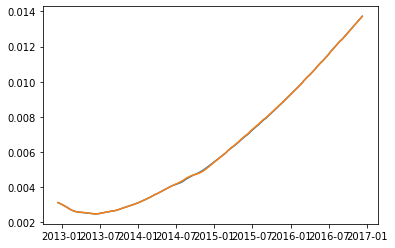

In [16]:
dates = [ spot+Period(i,Weeks) for i in range(0, 52*4+1) ]
rates_0 = [ euribor6m_curve_0.forwardRate(d, euribor6m.maturityDate(d),
                                          Actual360(), Simple).rate() for d in dates ]
rates = [ euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d),
                                      Actual360(), Simple).rate() for d in dates ]

plt.plot([d.to_date() for d in dates], rates)
plt.plot([d.to_date() for d in dates], rates_0)

# 12m Euribor

In [17]:
euribor12m = Euribor1Y()
helpers = [ DepositRateHelper(QuoteHandle(SimpleQuote(0.54/100)),
                              Period(12,Months), 2,
                              TARGET(), Following, False, Actual360()) ]
helpers += [ FraRateHelper(QuoteHandle(SimpleQuote(0.5070/100)),
                           12, euribor12m) ]
helpers += [SwapRateHelper(QuoteHandle(SimpleQuote((rate+basis)/100)), 
                           Period(tenor, Years), TARGET(),
                           Annual, Unadjusted, Thirty360(Thirty360.BondBasis),
                           euribor12m, QuoteHandle(), Period(0, Days),
                           discount_curve) 
            for rate, basis, tenor in [(0.424, 0.179, 3), (0.576, 0.164, 4),
                                       (0.762, 0.151, 5), (0.954, 0.139, 6),
                                       (1.135, 0.130, 7), (1.303, 0.123, 8),
                                       (1.452, 0.118, 9), (1.584, 0.113, 10),
                                       (1.809, 0.106, 12), (2.037, 0.093, 15),
                                       (2.187, 0.080, 20), (2.234, 0.072, 25),
                                       (2.256, 0.066, 30)] ]
synth_helpers = [DepositRateHelper(QuoteHandle(SimpleQuote(rate/100)),
                                   Period(*tenor), 2,
                                   TARGET(), Following, False, Actual360()) 
                 for rate, tenor in [(0.6537, (1,Months)), (0.6187, (3,Months)),
                                     (0.5772, (6,Months)), (0.5563, (9,Months))] ]
synth_helpers += [FraRateHelper(QuoteHandle(SimpleQuote(rate/100)),
                                months_to_start, euribor12m)
                  for rate, months_to_start in [(0.4974, 3), (0.4783, 6), (0.4822, 9),
                                                (0.5481, 15), (0.6025, 18)] ]
last_basis = 0.066
synth_helpers += [SwapRateHelper(QuoteHandle(SimpleQuote((rate+last_basis)/100)),
                                 Period(tenor, Years), TARGET(),
                                 Annual, Unadjusted, Thirty360(Thirty360.BondBasis),
                                 euribor12m, QuoteHandle(), Period(0, Days),
                                 discount_curve)
                  for rate, tenor in [(2.295, 35), (2.348, 40),
                                      (2.421, 50), (2.463, 60)] ]
euribor12m_curve = PiecewiseLogCubicDiscount(2, TARGET(),
                                             helpers+synth_helpers,
                                             Actual365Fixed())
euribor12m_curve.enableExtrapolation()

euribor12m_curve_0 = PiecewiseLogCubicDiscount(2, TARGET(), helpers,
                                               Actual365Fixed())
euribor12m_curve_0.enableExtrapolation()

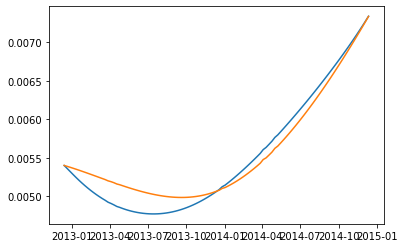

In [18]:
spot = euribor12m_curve.referenceDate()
dates = [ spot+Period(i,Weeks) for i in range(0, 2*52+1) ]
rates_0 = [ euribor12m_curve_0.forwardRate(d, euribor12m.maturityDate(d),
                                           Actual360(), Simple).rate()
           for d in dates ]
rates = [ euribor12m_curve.forwardRate(d, euribor12m.maturityDate(d),
                                       Actual360(), Simple).rate()
         for d in dates ]

plt.plot([d.to_date() for d in dates], rates)
plt.plot([d.to_date() for d in dates], rates_0)

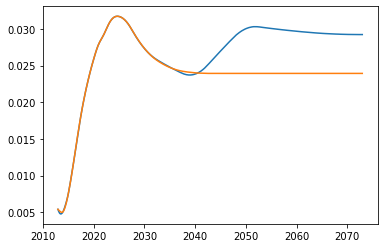

In [19]:
dates = [ spot+Period(i,Months) for i in range(0, 60*12+1) ]
rates_0 = [ euribor12m_curve_0.forwardRate(d, euribor12m.maturityDate(d),
                                           Actual360(), Simple).rate()
           for d in dates ]
rates = [ euribor12m_curve.forwardRate(d, euribor12m.maturityDate(d),
                                       Actual360(), Simple).rate()
         for d in dates ]

plt.plot([d.to_date() for d in dates], rates)
plt.plot([d.to_date() for d in dates], rates_0)

# 3m Euribor

5.930322209436123e-05 0.25


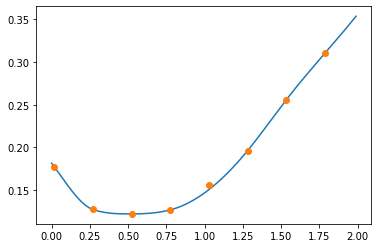

In [20]:
euribor3m = Euribor3M()
helpers = [ DepositRateHelper(QuoteHandle(SimpleQuote(0.179/100)),
                              Period(3,Months), 3,
                              TARGET(), Following, False, Actual360()) ]
helpers += [FuturesRateHelper(QuoteHandle(SimpleQuote(100-rate)),
                              start_date, euribor3m, QuoteHandle())
            for rate, start_date in [(0.1775, Date(19, December, 2012)),
                                     (0.1274, Date(20, March, 2013)),
                                     (0.1222, Date(19, June, 2013)),
                                     (0.1269, Date(18, September, 2013)),
                                     (0.1565, Date(18, December, 2013)),
                                     (0.1961, Date(19, March, 2014)),
                                     (0.2556, Date(18, June, 2014)),
                                     (0.3101, Date(17, September, 2014))] ]
helpers += [SwapRateHelper(QuoteHandle(SimpleQuote((rate-basis)/100)),
                           Period(tenor, Years), TARGET(),
                           Annual, Unadjusted, Thirty360(Thirty360.BondBasis),
                           euribor3m, QuoteHandle(), Period(0, Days),
                           discount_curve)
            for rate, basis, tenor in [(0.424, 0.1395, 3), (0.576, 0.1390, 4),
                                       (0.762, 0.1395, 5), (0.954, 0.1375, 6),
                                       (1.135, 0.1350, 7), (1.303, 0.1320, 8),
                                       (1.452, 0.1285, 9), (1.584, 0.1250, 10),
                                       (1.809, 0.1170, 12), (2.037, 0.1045, 15),
                                       (2.187, 0.0885, 20), (2.234, 0.0780, 25),
                                       (2.256, 0.0700, 30), (2.348, 0.0600, 40),
                                       (2.421, 0.0540, 50)] ]

synth_helpers = [DepositRateHelper(QuoteHandle(SimpleQuote(rate/100)),
                                   Period(*tenor), 2,
                                   TARGET(), Following, False, Actual360())
                 for rate, tenor in [(0.1865, (2,Weeks)), (0.1969, (3,Weeks)),
                                     (0.1951, (1,Months)), (0.1874, (2,Months))] ]
synth_helpers += [SwapRateHelper(QuoteHandle(SimpleQuote((rate-basis)/100)),
                                 Period(tenor, Years), TARGET(),
                                 Annual, Unadjusted, Thirty360(Thirty360.BondBasis),
                                 euribor3m, QuoteHandle(), Period(0, Days),
                                 discount_curve)
                  for rate, basis, tenor in [(2.295, 0.0650, 35), (2.463, 0.0540, 60)] ]

futures = [(0.1775, Date(19, December, 2012)),
           (0.1274, Date(20, March, 2013)),
           (0.1222, Date(19, June, 2013)),
           (0.1269, Date(18, September, 2013)),
           (0.1565, Date(18, December, 2013)),
           (0.1961, Date(19, March, 2014)),
           (0.2556, Date(18, June, 2014)),
           (0.3101, Date(17, September, 2014))]

spot = euribor6m_curve.referenceDate()
day_counter = euribor3m.dayCounter()
quotes, times = zip(*[(q, day_counter.yearFraction(spot, d)) for q,d in futures])
f = MonotonicCubicNaturalSpline(times[:4]+times[5:], quotes[:4]+quotes[5:])

fig, ax = plt.subplots()
ts, fs = zip(*[(t,f(t, True)) for t in numpy.arange(0.0, 2.0, 0.01)])
ax.plot(ts,fs)
_ = ax.plot(times,quotes,'o')

J = (quotes[4] - f(times[4]))/100
tau = day_counter.yearFraction(Date(18,December,2013), Date(18,March,2014))
print(J, tau)

In [21]:
jumps = [QuoteHandle(SimpleQuote(math.exp(-J*tau)))]
jump_dates = [Date(31,December,2013)]
euribor3m_curve = PiecewiseLogCubicDiscount(2, TARGET(),
                                            helpers+synth_helpers,
                                            Actual365Fixed(),
                                            jumps, jump_dates)
euribor3m_curve.enableExtrapolation()

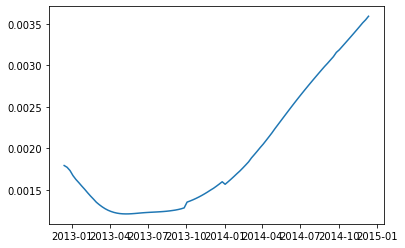

In [22]:
spot = euribor3m_curve.referenceDate()
dates = [ spot+Period(i,Weeks) for i in range(0, 2*52+1) ]
rates = [ euribor3m_curve.forwardRate(d, euribor3m.maturityDate(d),
                                      Actual360(), Simple).rate()
         for d in dates ]

plt.plot([d.to_date() for d in dates], rates)

# 1m Euribor

In [23]:
euribor1m = Euribor1M()
helpers = [ DepositRateHelper(QuoteHandle(SimpleQuote(0.110/100)),
                              Period(1,Months), 2,
                              TARGET(), Following, False, Actual360()) ]
helpers += [SwapRateHelper(QuoteHandle(SimpleQuote(rate/100)),
                           Period(tenor, Months), TARGET(),
                           Monthly, Unadjusted, Thirty360(Thirty360.BondBasis),
                           euribor1m, QuoteHandle(), Period(0, Days),
                           discount_curve)
            for rate, tenor in [(0.106, 2), (0.096, 3), (0.085, 4), (0.079, 5),
                                (0.075, 6), (0.071, 7), (0.069, 8), (0.066, 9),
                                (0.065, 10), (0.064, 11), (0.063, 12)] ]
helpers += [SwapRateHelper(QuoteHandle(SimpleQuote((rate-basis)/100)),
                           Period(tenor, Years), TARGET(),
                           Annual, Unadjusted, Thirty360(Thirty360.BondBasis),
                           euribor1m, QuoteHandle(), Period(0, Days),
                           discount_curve)
            for rate, basis, tenor in [(0.324, 0.226, 2), (0.424, 0.238, 3),
                                       (0.576, 0.246, 4), (0.762, 0.250, 5),
                                       (0.954, 0.250, 6), (1.135, 0.248, 7),
                                       (1.303, 0.245, 8), (1.452, 0.241, 9),
                                       (1.584, 0.237, 10), (1.703, 0.233, 11),
                                       (1.809, 0.228, 12), (2.037, 0.211, 15),
                                       (2.187, 0.189, 20), (2.234, 0.175, 25),
                                       (2.256, 0.163, 30)] ]
synth_helpers = [DepositRateHelper(QuoteHandle(SimpleQuote(rate/100)),
                                   Period(*tenor), 2,
                                   TARGET(), Following, False, Actual360())
                 for rate, tenor in [(0.0661, (1,Days)), (0.098, (1,Weeks)),
                                     (0.0993, (2,Weeks)), (0.1105, (3,Weeks))] ]
last_basis = 0.163
synth_helpers += [SwapRateHelper(QuoteHandle(SimpleQuote((rate-last_basis)/100)),
                                 Period(tenor, Years), TARGET(),
                                 Annual, Unadjusted, Thirty360(Thirty360.BondBasis),
                                 euribor1m, QuoteHandle(), Period(0, Days),
                                 discount_curve)
                  for rate, tenor in [(2.295, 35), (2.348, 40),
                                      (2.421, 50), (2.463, 60)] ]
J = 0.0016
t_j = euribor1m.dayCounter().yearFraction(Date(31,December,2012), Date(2,January,2013))
B = 1.0/(1.0+J*t_j)
jumps = [QuoteHandle(SimpleQuote(B))]
jump_dates = [Date(31,December,2013)]

euribor1m_curve = PiecewiseLogCubicDiscount(2, TARGET(),
                                            helpers+synth_helpers,
                                            Actual365Fixed(),
                                            jumps, jump_dates)
euribor1m_curve.enableExtrapolation()

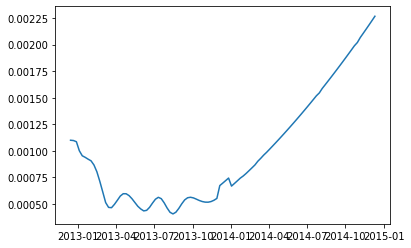

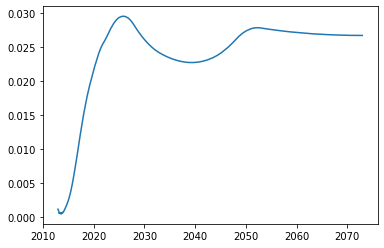

In [24]:
spot = euribor1m_curve.referenceDate()
dates = [ spot+Period(i,Weeks) for i in range(0, 2*52+1) ]
rates = [ euribor1m_curve.forwardRate(d, euribor1m.maturityDate(d),
                                      Actual360(), Simple).rate()
         for d in dates ]

plt.plot([d.to_date() for d in dates], rates)
plt.show()
dates = [ spot+Period(i,Months) for i in range(0, 60*12+1) ]
rates = [ euribor1m_curve.forwardRate(d, euribor1m.maturityDate(d), 
                                      Actual360(), Simple).rate() for d in dates ]
plt.plot([d.to_date() for d in dates], rates)

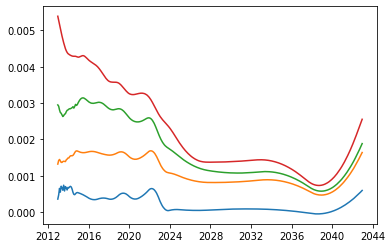

In [26]:
dates = [ spot+Period(i,Months) for i in range(0, 12*30+1) ]

def basis(curve, tenor):
    results = []
    for d in dates:
        d2 = TARGET().advance(d, Period(*tenor), ModifiedFollowing)
        FRA1 = curve.forwardRate(d, d2, Actual360(), Simple).rate()
        FRA2 = eonia_curve.forwardRate(d, d2, Actual360(), Simple).rate()
        results.append(FRA1-FRA2)
    return results

basis_1m = basis(euribor1m_curve, (1,Months))
basis_3m = basis(euribor3m_curve, (3,Months))
basis_6m = basis(euribor6m_curve, (6,Months))
basis_12m = basis(euribor12m_curve, (12,Months))

plt.plot([d.to_date() for d in dates], basis_1m)
plt.plot([d.to_date() for d in dates], basis_3m)
plt.plot([d.to_date() for d in dates], basis_6m)
plt.plot([d.to_date() for d in dates], basis_12m)



In [ ]:
today = eonia_curve_c.referenceDate()
end = today + Period(2,Years)
dates = [ Date(serial) for serial in range(today.serialNumber(), end.serialNumber()+1) ]
rates_c = [ eonia_curve_c.forwardRate(d, 
                                      TARGET().advance(d,1,Days), 
                                      Actual360(), 
                                      Simple).rate() for d in dates ]
plt.plot([d.to_date() for d in dates], rates_c, linewidth=2.0)

#utils.plot_curve(plt, dates, [(rates_c,'-')])

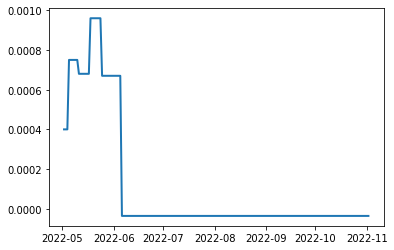

In [13]:
eonia_curve_ff = PiecewiseFlatForward(0, TARGET(),helpers, Actual365Fixed())
eonia_curve_ff.enableExtrapolation()
end = today + Period(6,Months)
dates = [ Date(serial) for serial in range(today.serialNumber(), end.serialNumber()+1) ]
rates_ff = [ eonia_curve_ff.forwardRate(d, 
                                        TARGET().advance(d,1,Days), 
                                        Actual360(), 
                                        Simple).rate() for d in dates ]
plt.plot([d.to_date() for d in dates], rates_ff, linewidth=2.0)

In [20]:
nodes = list(eonia_curve_ff.nodes())
nodes[6] = (nodes[6][0], (nodes[5][1]+nodes[7][1])/2.0)


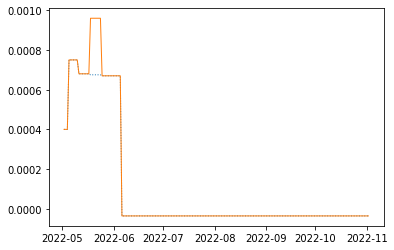

In [21]:
temp_dates, temp_rates = zip(*nodes)
temp_curve = ForwardCurve(temp_dates, temp_rates, eonia_curve_ff.dayCounter())
temp_rates = [ temp_curve.forwardRate(d, 
                                      TARGET().advance(d,1,Days), 
                                      Actual360(), 
                                      Simple).rate() for d in dates ]
plt.plot([d.to_date() for d in dates], temp_rates, linewidth=1.0, linestyle=':')
plt.plot([d.to_date() for d in dates], rates_ff, linewidth=1.0, linestyle='-')

In [ ]:
d1 = Date(31,December,2012) - Period(1,Weeks)
d2 = Date(31,December,2012) + Period(1,Weeks)

F = eonia_curve_ff.forwardRate(d1, d2, Actual360(), Simple).rate()
F_1 = temp_curve.forwardRate(d1, d2, Actual360(), Simple).rate()

